In [146]:
import pandas as pd
import numpy as np
from datetime import timedelta, datetime

In [147]:
df = pd.read_csv('KC_case_data.csv')

Вы выгрузили данные из AppMetrica за период с 1 января по 31 марта 2020, только по пользователям, зарегистрированным позднее 1 января 2020.

Описание данных 

- date – дата совершения события

- event - событие

app_install – установка приложения

app_start – открыть приложения

registration – зарегистрироваться 

search – перейти на страницу поиска товаров (каталог)

open_item – открыть товар

choose_item – отправить товар в корзину

tap_basket – перейти в корзину

purchase – подтверждение покупки
- gender – пол пользователя

- os_name – платформа пользователя

- city – город пользователя

- device_id – идентификатор устройства пользователя

- urm_source – канал, с которого пришел пользователь

yandex-direct – Яндекс директ

google_ads – реклама в Google

vk_ads – реклама в ВК

instagram_ads – реклама в instagram

facebook_ads – реклама в facebook

referral – акция «приведи друга»

Если стоит ‘-’, то канал не определен или это скачивание приложения напрямую или посещение не с рекламы  
- purchase_sum – стоимость покупки (при совершении события ‘purchase’)

Обратите внимание на следующее:

- В выгрузке только уникальные действия пользователей за каждый день 

- Можно миновать стадию установки приложения, если оно было установлено ранее

- Можно миновать стадию регистрации, если пользователь был уже залогинен на момент сессии. Однако незарегистрированные пользователи не могут оформить покупку. 

In [148]:
df

,date,event,purchase_sum,os_name,device_id,gender,city,utm_source
0,2020-01-01,app_start,NaN,android,669460,female,Moscow,-
1,2020-01-01,app_start,NaN,ios,833621,male,Moscow,vk_ads
2,2020-01-01,app_start,NaN,android,1579237,male,Saint-Petersburg,referal
3,2020-01-01,app_start,NaN,android,1737182,female,Moscow,facebook_ads
4,2020-01-01,app_start,NaN,ios,4029024,female,Moscow,facebook_ads
...,...,...,...,...,...,...,...,...
2747963,2020-03-31,register,NaN,android,2984778,male,Saint-Petersburg,facebook_ads
2747964,2020-03-31,register,NaN,ios,27301864,male,Moscow,-
2747965,2020-03-31,register,NaN,ios,1294285,female,Saint-Petersburg,google_ads
2747966,2020-03-31,register,NaN,android,3010574,female,Saint-Petersburg,google_ads


In [149]:
df.date.min()

'2020-01-01'

In [150]:
df.date.max()

'2020-03-31'

In [151]:
df.isnull().sum()

date                  0
event                 0
purchase_sum    2606585
os_name               0
device_id             0
gender                0
city                  0
utm_source            0
dtype: int64

In [152]:
df['date'] =  pd.to_datetime(df['date'])

In [153]:
# MAU февраля:
df[(df.date.dt.month == 2) & (df.event == 'app_start')]['device_id'].nunique()

75032

In [154]:
#Количество установок в январе:
df[(df.date.dt.month == 1) & (df.event == 'app_install')]['device_id'].nunique()

80297

Присвойте пользователям когорты по дню установки приложения и посчитайте для них  конверсию из установки в покупку в течение 7 дней. Для какой когорты конверсия была наибольшей? 

Примечание: считаем пользователя сконвертировавшимся, если с момента установки до совершения первой покупки прошло не более 7 дней.

In [155]:
# присвоим когорты по дате установки приложения
cohort = df[df.event == 'app_install'][['date', 'device_id']]

In [156]:
cohort

,date,device_id
2515061,2020-01-01,4921563
2515062,2020-01-01,1311583
2515063,2020-01-01,23006325
2515064,2020-01-01,5645652
2515065,2020-01-01,8798567
...,...,...
2669653,2020-03-31,19717968
2669654,2020-03-31,32966665
2669655,2020-03-31,6335964
2669656,2020-03-31,29155826


In [157]:
#  считаем дату первой покупки
purchase = df[df.event == 'purchase'][['date', 'device_id']].groupby('device_id', as_index=False)['date'].min()
purchase

,device_id,date
0,4014,2020-02-01
1,4046,2020-01-04
2,4060,2020-03-07
3,4120,2020-01-07
4,4125,2020-01-07
...,...,...
70870,35321120,2020-03-25
70871,35326839,2020-03-28
70872,35342310,2020-03-27
70873,35367797,2020-03-29


объеденим когорты, первую покупку и посчитаем конверсию за первые 7 дней

In [158]:
merged_table = cohort.merge(purchase, how='left', on="device_id") \
  .rename(columns={"date_x": "cohort", "date_y": "first_buy"})

merged_table

,cohort,device_id,first_buy
0,2020-01-01,4921563,2020-01-10
1,2020-01-01,1311583,NaT
2,2020-01-01,23006325,2020-01-01
3,2020-01-01,5645652,NaT
4,2020-01-01,8798567,NaT
...,...,...,...
154592,2020-03-31,19717968,NaT
154593,2020-03-31,32966665,NaT
154594,2020-03-31,6335964,NaT
154595,2020-03-31,29155826,NaT


In [159]:
# считаем кол-во дней с момента покупки 
merged_table['days_diff'] = merged_table.first_buy - merged_table.cohort
merged_table['days_diff'] = merged_table.days_diff.fillna(pd.Timedelta(seconds=0))
merged_table

,cohort,device_id,first_buy,days_diff
0,2020-01-01,4921563,2020-01-10,9 days
1,2020-01-01,1311583,NaT,0 days
2,2020-01-01,23006325,2020-01-01,0 days
3,2020-01-01,5645652,NaT,0 days
4,2020-01-01,8798567,NaT,0 days
...,...,...,...,...
154592,2020-03-31,19717968,NaT,0 days
154593,2020-03-31,32966665,NaT,0 days
154594,2020-03-31,6335964,NaT,0 days
154595,2020-03-31,29155826,NaT,0 days


In [160]:
# создаем столбец True/False, который показывает соотвествие условию - покупка в течении 7дней
merged_table['t/f'] = (merged_table.first_buy.notna()) & (merged_table.days_diff <= '7days')
merged_table["t/f"] = merged_table["t/f"].astype(int)
merged_table

,cohort,device_id,first_buy,days_diff,t/f
0,2020-01-01,4921563,2020-01-10,9 days,0
1,2020-01-01,1311583,NaT,0 days,0
2,2020-01-01,23006325,2020-01-01,0 days,1
3,2020-01-01,5645652,NaT,0 days,0
4,2020-01-01,8798567,NaT,0 days,0
...,...,...,...,...,...
154592,2020-03-31,19717968,NaT,0 days,0
154593,2020-03-31,32966665,NaT,0 days,0
154594,2020-03-31,6335964,NaT,0 days,0
154595,2020-03-31,29155826,NaT,0 days,0


In [161]:
# считаем конверсию
merged_table = merged_table.groupby('cohort', as_index=False).agg({'device_id' : 'count', 't/f' : 'sum'})
merged_table['cr_%'] = round(merged_table['t/f'] / merged_table.device_id * 100, 1)
merged_table.sort_values(by='cr_%')
merged_table

,cohort,device_id,t/f,cr_%
0,2020-01-01,3579,1408,39.3
1,2020-01-02,3144,1186,37.7
2,2020-01-03,2402,834,34.7
3,2020-01-04,1831,639,34.9
4,2020-01-05,1671,587,35.1
...,...,...,...,...
86,2020-03-27,1199,277,23.1
87,2020-03-28,1091,209,19.2
88,2020-03-29,1117,223,20.0
89,2020-03-30,994,204,20.5


С какого платного маркетингового канала пришло больше всего новых пользователей? 

In [162]:
df.query("utm_source != '-'").groupby('utm_source')['device_id'].nunique().idxmax()

'yandex-direct'

Пользователи, пришедшие с каких каналов, показали самую низкую конверсию в первую покупку?

In [163]:
# первая покупка в разбивке по UTM
purchase = df.query('event == "purchase"').groupby(['device_id', 'utm_source'], as_index=False)['date'].min() \
    .groupby('utm_source', as_index=False)['device_id'].count()

In [164]:
# первый запуск приложения в разбивке по UTM
app_start = df.query('event == "app_start"').groupby(['device_id', 'utm_source'], as_index=False)['date'].min() \
    .groupby('utm_source', as_index=False)['device_id'].count()

In [165]:
# объединим данные в одну таблицу и посчитаем конверсию
table = purchase.merge(app_start, on='utm_source') \
  .rename(columns={"device_id_x": "c_purchase", "device_id_y": "c_app_start"})

table['CR'] = table.c_purchase / table.c_app_start
# найдем канал с самой низкой конверсией
table.query("utm_source != '-'").set_index("utm_source").CR.idxmin()


'yandex-direct'

Пользователи, пришедшие с какого канала, имеют медианный первый чек выше? (учитываются только первые покупки пользователей)

In [176]:
# с помощью head вытащим данные по первым первым покупкам. затем посчитаем медиану
first_median_cheque = df.query('event == "purchase"').sort_values(by='date').groupby(['device_id', 'utm_source'], as_index=False).head(1) \
    .groupby('utm_source', as_index=False)['purchase_sum'].median() \
     .sort_values(by='purchase_sum')

first_median_cheque

,utm_source,purchase_sum
2,google_ads,390.0
1,facebook_ads,390.5
6,yandex-direct,392.5
5,vk_ads,393.0
3,instagram_ads,393.5
4,referal,395.0
0,-,398.5


In [179]:
first_median_cheque.query("utm_source != '-'").set_index("utm_source").purchase_sum.idxmax()

'referal'

Данные по затратам на рекламу:

Яндекс – 10 491 707 руб.

Гугл – 10 534 878 руб.

Фейсбук – 8 590 498 руб.

Инстаграм – 8 561626 руб.

ВК – 9 553 531руб.

Расходы на реферальную программу: если пользователь приведет друга и последний совершит первую покупку, то оба получат по 100 рублей.

**Какой платный канал привлечения (среди рекламных) имеет самый высокий ROMI?**

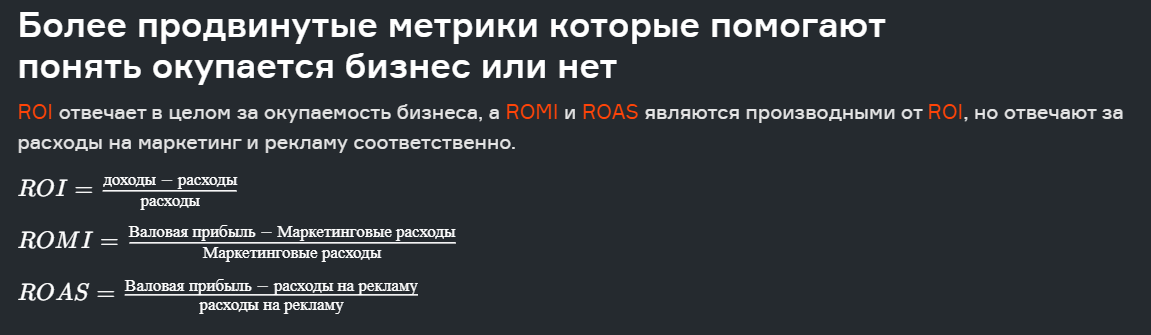

In [169]:
utm_revenue = df.groupby('utm_source')['purchase_sum'].sum()

In [170]:
utm_revenue

utm_source
-                21449749.5
facebook_ads     12249901.0
google_ads       12868276.0
instagram_ads    14546969.0
referal           8837044.5
vk_ads           16389652.5
yandex-direct    13915368.0
Name: purchase_sum, dtype: float64

In [171]:
dictionary = {
    'yandex-direct' : 10491707,
    'google_ads' : 10534878,
    'facebook_ads' : 8590498,
    'instagram_ads' : 8561626,
    'vk_ads' : 9553531
    }

marketing_cost = pd.Series(dictionary, name='marketing_cost')
marketing_cost

yandex-direct    10491707
google_ads       10534878
facebook_ads      8590498
instagram_ads     8561626
vk_ads            9553531
Name: marketing_cost, dtype: int64

In [172]:
finance = pd.concat([marketing_cost, utm_revenue], axis=1, names=['marketing_cost','utm_revenue'])
finance

,marketing_cost,purchase_sum
yandex-direct,10491707.0,13915368.0
google_ads,10534878.0,12868276.0
facebook_ads,8590498.0,12249901.0
instagram_ads,8561626.0,14546969.0
vk_ads,9553531.0,16389652.5
-,NaN,21449749.5
referal,NaN,8837044.5


In [173]:
finance['ROMI'] = round((finance.purchase_sum - finance.marketing_cost) / marketing_cost, 4)

In [174]:
finance.idxmax()['ROMI']

'vk_ads'